In [0]:
!pip install catboost
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,LabelBinarizer,OneHotEncoder,StandardScaler,OrdinalEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import tensorflow as tf
from catboost import Pool, CatBoostClassifier, cv
from sklearn.model_selection import GridSearchCV , cross_val_score
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,roc_curve,auc
import keras
import seaborn as sns
from termcolor import colored
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb


In [0]:
df_train = pd.read_csv('drive/My Drive/KOS/credit_card_default_train.csv')
df_test = pd.read_csv('drive/My Drive/KOS/credit_card_default_test.csv')

df_train.drop('Client_ID',axis=1,inplace=True)
df_test.drop('Client_ID',axis=1,inplace=True)

df_train.head()

In [0]:
def age_enc(df):  
  for i,val in enumerate(df['AGE']):
    if (val == "31-45"):
      df['AGE'][i] = 1
    elif (val == 'Less than 30'):
      df['AGE'][i] = 0
    elif (val == "46-65"):
      df['AGE'][i] = 2
    elif (val == 'More than 65'):
      df['AGE'][i] = 3

def balance (df):
  for i,val in enumerate(df['Balance_Limit_V1']):
    if (val == "2.5M"):
      df['Balance_Limit_V1'][i] = 2500000
    elif (val == '1.5M'):
      df['Balance_Limit_V1'][i] = 1500000
    elif (val == "1M"):
      df['Balance_Limit_V1'][i] = 1000000
    elif (val == '400K'):
      df['Balance_Limit_V1'][i] = 400000
    elif (val == '300K'):
      df['Balance_Limit_V1'][i] = 300000
    elif (val == '200K'):
      df['Balance_Limit_V1'][i] = 200000
    elif (val == '100K'):
      df['Balance_Limit_V1'][i] = 100000
    elif (val == ' 500K'):
      df['Balance_Limit_V1'][i] = 500000
  df['Balance_Limit_V1'] = pd.to_numeric(df['Balance_Limit_V1'])

def encode_cat(df):
  fields = ['Gender','EDUCATION_STATUS','MARITAL_STATUS']
  for field in fields:
    encoder = LabelEncoder()
    encoded = df[field]
    df[field] = encoder.fit_transform(encoded)
    encoding = {}

    for idx,value in enumerate(encoder.classes_):
        encoding[idx]=value
        
    print("%s: "%field,encoding)

def normalize(df):
  col_to_norm = ['Balance_Limit_V1', 'DUE_AMT_JULY', 'DUE_AMT_AUG', 'DUE_AMT_SEP', 'DUE_AMT_OCT',
       'DUE_AMT_NOV', 'DUE_AMT_DEC', 'PAID_AMT_JULY', 'PAID_AMT_AUG',
       'PAID_AMT_SEP', 'PAID_AMT_OCT', 'PAID_AMT_NOV', 'PAID_AMT_DEC']
  df[col_to_norm] = df[col_to_norm].apply(lambda x : (x-np.mean(x))/np.std(x))

In [0]:
age_enc(df_train)
balance(df_train)
encode_cat(df_train)
normalize(df_train)

age_enc(df_test)
balance(df_test)
encode_cat(df_test)
normalize(df_test)


Gender:  {0: 'F', 1: 'M'}
EDUCATION_STATUS:  {0: 'Graduate', 1: 'High School', 2: 'Other'}
MARITAL_STATUS:  {0: 'Other', 1: 'Single'}
Gender:  {0: 'F', 1: 'M'}
EDUCATION_STATUS:  {0: 'Graduate', 1: 'High School', 2: 'Other'}
MARITAL_STATUS:  {0: 'Other', 1: 'Single'}


In [0]:
df_train.head()

In [0]:
corr_matrix = df_train.corr()
print(corr_matrix['NEXT_MONTH_DEFAULT'].sort_values(ascending=False))

NEXT_MONTH_DEFAULT    1.000000
PAY_JULY              0.324362
PAY_AUG               0.260531
PAY_SEP               0.229338
PAY_OCT               0.212407
PAY_NOV               0.201231
PAY_DEC               0.187095
EDUCATION_STATUS      0.038902
MARITAL_STATUS        0.027905
DUE_AMT_DEC          -0.006521
DUE_AMT_NOV          -0.007614
DUE_AMT_OCT          -0.009755
DUE_AMT_SEP          -0.014722
DUE_AMT_AUG          -0.015180
DUE_AMT_JULY         -0.020010
Gender               -0.041649
PAID_AMT_DEC         -0.052466
PAID_AMT_NOV         -0.053849
PAID_AMT_OCT         -0.056143
PAID_AMT_SEP         -0.057808
PAID_AMT_AUG         -0.059039
PAID_AMT_JULY        -0.072891
Balance_Limit_V1     -0.148938
Name: NEXT_MONTH_DEFAULT, dtype: float64


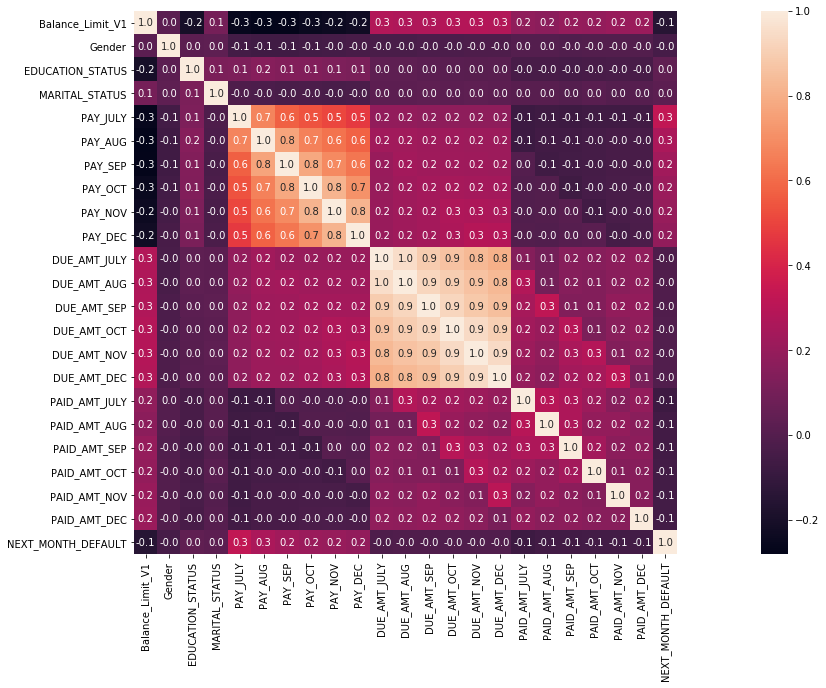

In [20]:
correlation = df_train.corr()
plt.subplots(figsize=(30,10))
sns.heatmap( correlation, square=True, annot=True, fmt=".1f" )

In [0]:
X = df_train.iloc[:,:-1].values
y = df_train.iloc[:,-1].values
df_test.head()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [0]:
model = CatBoostClassifier(eval_metric='Accuracy',colsample_bylevel=0.5,max_depth=8,n_estimators=500,learning_rate=0.01,use_best_model=True,random_seed=42)
model.fit(X_train,y_train,eval_set=(X_test,y_test))
y_pred = model.predict(X_test)
#Making the Confusion Matrix
cm = confusion_matrix(y_test, (y_pred>0.5))
print(colored('The Confusion Matrix is: ', 'red'),'\n', cm)
# Calculate the accuracy on test set
predict_accuracy_on_test_set = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1]+cm[1,0] + cm[0,1])
print(colored('The Accuracy on Test Set is: ', 'blue'), colored(predict_accuracy_on_test_set, 'blue'))

0:	learn: 0.8197917	test: 0.8239583	best: 0.8239583 (0)	total: 81.5ms	remaining: 40.7s
1:	learn: 0.8193229	test: 0.8250000	best: 0.8250000 (1)	total: 101ms	remaining: 25.1s
2:	learn: 0.8192708	test: 0.8243750	best: 0.8250000 (1)	total: 123ms	remaining: 20.4s
3:	learn: 0.8203125	test: 0.8254167	best: 0.8254167 (3)	total: 142ms	remaining: 17.7s
4:	learn: 0.8190104	test: 0.8239583	best: 0.8254167 (3)	total: 164ms	remaining: 16.2s
5:	learn: 0.8199479	test: 0.8250000	best: 0.8254167 (3)	total: 183ms	remaining: 15.1s
6:	learn: 0.8195833	test: 0.8250000	best: 0.8254167 (3)	total: 202ms	remaining: 14.2s
7:	learn: 0.8191146	test: 0.8247917	best: 0.8254167 (3)	total: 220ms	remaining: 13.5s
8:	learn: 0.8190625	test: 0.8252083	best: 0.8254167 (3)	total: 241ms	remaining: 13.1s
9:	learn: 0.8195833	test: 0.8254167	best: 0.8254167 (3)	total: 262ms	remaining: 12.8s
10:	learn: 0.8200000	test: 0.8254167	best: 0.8254167 (3)	total: 286ms	remaining: 12.7s
11:	learn: 0.8199479	test: 0.8254167	best: 0.8254167

In [0]:
roc=roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model = pd.DataFrame([['CAT Boost', acc,prec,rec, f1,roc]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

model

,Model,Accuracy,Precision,Recall,F1 Score,ROC
0,CAT Boost,0.82875,0.716141,0.365877,0.484316,0.662511


In [0]:
y_pred = model.predict(df_test)

In [0]:
submission = pd.read_csv('drive/My Drive/KOS/credit_card_default_test.csv')
submission.loc[:,'NEXT_MONTH_DEFAULT'] = np.uint8(y_pred)
submission.to_csv("sub1.csv",index=False)